# code_test excercise

# imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings; warnings.filterwarnings(action='ignore')

# load datasets
from sklearn import datasets

# model_selection.splitter
from sklearn.model_selection import train_test_split       # function

# model_selection.model_validation
from sklearn.model_selection import KFold, StratifiedKFold # cross-validator
from sklearn.model_selection import cross_val_score

# model_selection.hyper_parameter_optimizer
from sklearn.model_selection import GridSearchCV

# --------------------------------------------------
# models/estimators
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# models : boost
import xgboost as xgb
import lightgbm
# --------------------------------------------------

# preprocessing.encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # pd.get_dummies()

# preprocessing.scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# preprocessing.binarizing
from sklearn.preprocessing import Binarizer

# metrics.scores
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

# metrics.curves
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import roc_curve, plot_roc_curve

# metrics.reports
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report

# read dataset

In [2]:
df = pd.read_csv('./code_test/kote_train.csv')

# check dataset

## basic

In [3]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

## target balance check

In [5]:
df['target'].value_counts()

0.0    14381
1.0     4777
Name: target, dtype: int64

## missing val check ; nan_cols

In [6]:
df.isna().sum()[df.isna().sum() != 0].sort_values(ascending=False)

company_type           6140
company_size           5938
gender                 4508
major_discipline       2813
education_level         460
last_new_job            423
enrolled_university     386
experience               65
dtype: int64

### check_nan def

In [7]:
def check_nan(df):
    nan = df.isna().sum()[df.isna().sum() != 0]
    nan_cols = list(nan.index)
    nan_cnt  = df[nan_cols].isna().sum()
    rate = round(nan_cnt / df.shape[0] * 100, 2)
    nan_df = pd.DataFrame({'NAN_CNT':nan_cnt, 'RATE':rate})
    
    print(nan_df)
    print('-' * 30)
    print('nan_cols count =', len(nan_cols))
    print(nan_cols)

    for col in nan_cols:
        print('-' * 30)
        print(df[col].value_counts())
        print('value_counts =', df[col].count(), '/ nan_counts =', df[col].isna().sum())
    
    return nan_cols

nan_cols = check_nan(df)

                     NAN_CNT   RATE
gender                  4508  23.53
enrolled_university      386   2.01
education_level          460   2.40
major_discipline        2813  14.68
experience                65   0.34
company_size            5938  30.99
company_type            6140  32.05
last_new_job             423   2.21
------------------------------
nan_cols count = 8
['gender', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job']
------------------------------
Male      13221
Female     1238
Other       191
Name: gender, dtype: int64
value_counts = 14650 / nan_counts = 4508
------------------------------
no_enrollment       13817
Full time course     3757
Part time course     1198
Name: enrolled_university, dtype: int64
value_counts = 18772 / nan_counts = 386
------------------------------
Graduate          11598
Masters            4361
High School        2017
Phd                 414
Primary School      308
Name

# EDA & feature engineering

In [8]:
# 'id': 등록자 ID
# 'city': 지역코드
# 'city_development_index': 지역개발지수
# 'gender': 성별
# 'relevent_experience': 관련경험
# 'enrolled_university': 대학과정
# 'education_level': 교육수준
# 'major_discipline': 전공
# 'experience':경력(년)
# 'company_size': 소속회사 직원수
# 'company_type': 소속회사 유형
# 'last_new_job': 현재 직업 경력(년)
# 'training_hours': 교육 이수 시간
# 'target': 목표변수, 다른 일을 찾는 경우1, 아니면 0

## encoding

In [9]:
# 레벨 무관(onehot, get_dummies) ; gender, major_discipline
# 레벨 부여(labelencoder)        ; enrolled_university, education_level, experience, last_new_job

# get_dummies   ; label + onehot + fillna, feature_unique로 컬럼 생성하여 0or1 정리, 반드시 미리 결측처리, only df
# label, onehot ;input df, array, list 등

LabelEncoder()

### encode def

In [10]:
def encode(df):
    object_cols = list(df.dtypes[df.dtypes == 'object'].index)
    print('object_cols count =', len(object_cols))
    for col in object_cols:
        print('-' * 30)
        print(df[col].value_counts())
    return object_cols
object_cols = encode(df)

object_cols count = 10
------------------------------
city_103    4355
city_21     2702
city_16     1533
city_114    1336
city_160     845
            ... 
city_129       3
city_111       3
city_121       3
city_140       1
city_171       1
Name: city, Length: 123, dtype: int64
------------------------------
Male      13221
Female     1238
Other       191
Name: gender, dtype: int64
------------------------------
Has relevent experience    13792
No relevent experience      5366
Name: relevent_experience, dtype: int64
------------------------------
no_enrollment       13817
Full time course     3757
Part time course     1198
Name: enrolled_university, dtype: int64
------------------------------
Graduate          11598
Masters            4361
High School        2017
Phd                 414
Primary School      308
Name: education_level, dtype: int64
------------------------------
STEM               14492
Humanities           669
Other                381
Business Degree      327
Arts       

In [11]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [12]:
for col in object_cols:
    print('-' * 30)
    print(df[col].value_counts())

------------------------------
city_103    4355
city_21     2702
city_16     1533
city_114    1336
city_160     845
            ... 
city_129       3
city_111       3
city_121       3
city_140       1
city_171       1
Name: city, Length: 123, dtype: int64
------------------------------
Male      13221
Female     1238
Other       191
Name: gender, dtype: int64
------------------------------
Has relevent experience    13792
No relevent experience      5366
Name: relevent_experience, dtype: int64
------------------------------
no_enrollment       13817
Full time course     3757
Part time course     1198
Name: enrolled_university, dtype: int64
------------------------------
Graduate          11598
Masters            4361
High School        2017
Phd                 414
Primary School      308
Name: education_level, dtype: int64
------------------------------
STEM               14492
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major 

### get_dummies 연습

In [13]:
df2 = df.copy()
df2 = pd.get_dummies(df, columns=['gender', 'major_discipline'], drop_first=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   enrollee_id                       19158 non-null  int64  
 1   city                              19158 non-null  object 
 2   city_development_index            19158 non-null  float64
 3   relevent_experience               19158 non-null  object 
 4   enrolled_university               18772 non-null  object 
 5   education_level                   18698 non-null  object 
 6   experience                        19093 non-null  object 
 7   company_size                      13220 non-null  object 
 8   company_type                      13018 non-null  object 
 9   last_new_job                      18735 non-null  object 
 10  training_hours                    19158 non-null  int64  
 11  target                            19158 non-null  float64
 12  gend

### LabelEncoder 연습

In [14]:
for col in list(df2.columns)[1:11]:
    df2[col] = LabelEncoder().fit_transform(df2[col])
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   enrollee_id                       19158 non-null  int64  
 1   city                              19158 non-null  int32  
 2   city_development_index            19158 non-null  int64  
 3   relevent_experience               19158 non-null  int32  
 4   enrolled_university               19158 non-null  int32  
 5   education_level                   19158 non-null  int32  
 6   experience                        19158 non-null  int32  
 7   company_size                      19158 non-null  int32  
 8   company_type                      19158 non-null  int32  
 9   last_new_job                      19158 non-null  int32  
 10  training_hours                    19158 non-null  int64  
 11  target                            19158 non-null  float64
 12  gend

In [15]:
# city
df['city'] = df['city'].apply(lambda x: x[5:])
df['city'] = df['city'].astype('int32')
df['city'].unique()

array([103,  40,  21, 115, 162, 176, 160,  46,  61, 114,  13, 159, 102,
        67, 100,  16,  71, 104,  64, 101,  83, 105,  73,  75,  41,  11,
        93,  90,  36,  20,  57, 152,  19,  65,  74, 173, 136,  98,  97,
        50, 138,  82, 157,  89, 150,  70, 175,  94,  28,  59, 165, 145,
       142,  26,  12,  37,  43, 116,  23,  99, 149,  10,  45,  80, 128,
       158, 123,   7,  72, 106, 143,  78, 109,  24, 134,  48, 144,  91,
       146, 133, 126, 118,   9, 167,  27,  84,  54,  39,  79,  76,  77,
        81, 131,  44, 117, 155,  33, 141, 127,  62,  53,  25,   2,  69,
       120, 111,  30,   1, 140, 179,  55,  14,  42, 107,  18, 139, 180,
       166, 121, 129,   8,  31, 171])

### mapping def

In [16]:
def mapping(df, col):
    dict = {}
    
    for i in range(len(df[col].value_counts().index)):
        dict[df[col].value_counts().index[i]] = i
    
    df[col] = df[col].map(dict)
    return df[col].value_counts()
# mapping(df, 'gender')

In [17]:
# gender
mapping(df, 'gender')

0.0    13221
1.0     1238
2.0      191
Name: gender, dtype: int64

In [18]:
# relevent_experience
mapping(df, 'relevent_experience')

0    13792
1     5366
Name: relevent_experience, dtype: int64

In [19]:
# enrolled_university
dict = {'no_enrollment':0, 'Full time course':2, 'Part time course':1}
df['enrolled_university'] = df['enrolled_university'].map(dict)
df['enrolled_university'].value_counts()

0.0    13817
2.0     3757
1.0     1198
Name: enrolled_university, dtype: int64

In [20]:
# education_level
dict = {'Graduate':2,'Masters':3,'High School':1,'Phd':4,'Primary School':0}
df['education_level'] = df['education_level'].map(dict)
df['education_level'].value_counts()

2.0    11598
3.0     4361
1.0     2017
4.0      414
0.0      308
Name: education_level, dtype: int64

In [21]:
# experience
dict = {}
keys = ['>20', '5', '4', '3', '6', '2', '7', '10', '9', '8', '15', '11', '14', '1', '<1', '16', '12', '13', '17', '19', '18', '20']
vals = [21, 5, 4, 3, 6, 2, 7, 10, 9, 8, 15, 11, 14, 1, 0, 16, 12, 13, 17, 19, 18, 20]
for i in range(len(keys)):
    dict[keys[i]] = vals[i]

df['experience'] = df['experience'].map(dict)
df['experience'].value_counts()

21.0    3286
5.0     1430
4.0     1403
3.0     1354
6.0     1216
2.0     1127
7.0     1028
10.0     985
9.0      980
8.0      802
15.0     686
11.0     664
14.0     586
1.0      549
0.0      522
16.0     508
12.0     494
13.0     399
17.0     342
19.0     304
18.0     280
20.0     148
Name: experience, dtype: int64

In [22]:
# major_discipline
mapping(df, 'major_discipline')

0.0    14492
1.0      669
2.0      381
3.0      327
4.0      253
5.0      223
Name: major_discipline, dtype: int64

In [23]:
# company_size
dict = {'50-99':2, '100-500':3, '10000+':7, '10/49':1, '1000-4999':5, '<10':0, '500-999':4, '5000-9999':6}
df['company_size'] = df['company_size'].map(dict)
df['company_size'].value_counts()

2.0    3083
3.0    2571
7.0    2019
1.0    1471
5.0    1328
0.0    1308
4.0     877
6.0     563
Name: company_size, dtype: int64

In [24]:
# company_type
mapping(df, 'company_type')

0.0    9817
1.0    1001
2.0     955
3.0     603
4.0     521
5.0     121
Name: company_type, dtype: int64

In [25]:
# last_new_job
dict = {'1':1, '>4':5, '2':2, 'never':0, '4':4, '3':3, }
df['last_new_job'] = df['last_new_job'].map(dict)
df['last_new_job'].value_counts()

1.0    8040
5.0    3290
2.0    2900
0.0    2452
4.0    1029
3.0    1024
Name: last_new_job, dtype: int64

In [26]:
encode(df)

object_cols count = 0


[]

## fillna

In [27]:
nan_cols

['gender',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job']

In [28]:
# fillna mode
for col in nan_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [29]:
check_nan(df)

Empty DataFrame
Columns: [NAN_CNT, RATE]
Index: []
------------------------------
nan_cols count = 0
[]


[]

## binning

## score v0

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  int32  
 2   city_development_index  19158 non-null  float64
 3   gender                  19158 non-null  float64
 4   relevent_experience     19158 non-null  int64  
 5   enrolled_university     19158 non-null  float64
 6   education_level         19158 non-null  float64
 7   major_discipline        19158 non-null  float64
 8   experience              19158 non-null  float64
 9   company_size            19158 non-null  float64
 10  company_type            19158 non-null  float64
 11  last_new_job            19158 non-null  float64
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(10), int32(1), int64(3)
mem

In [31]:
def pr_curve(y_val, probas_pred):

    """threshold / precision, recall, f1 curve"""

    # plot_precision_recall_curve(model, X_val, y_val) # x=recall, y=precision
    precisions, recalls, thresholds = precision_recall_curve(y_val, probas_pred[:, 1])
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

    # settings
    plt.title('precision recall f1 curve')
    plt.gray()
    plt.xlabel('threshold')
    plt.ylabel('socre')

    # x, y values
    plt.plot(thresholds, precisions[:thresholds.shape[0]], label='precision', linestyle=':')
    plt.plot(thresholds, recalls[:thresholds.shape[0]],    label='recall',    linestyle='--')
    plt.plot(thresholds, f1_scores[:thresholds.shape[0]],  label='f1',        linestyle='solid')
    # valid linestyle = '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'

    plt.legend()
    plt.show()

    return thresholds, precisions, recalls, f1_scores

In [32]:
def split_xy(df, target):
    X = df.drop(target, axis=1)
    y = df[target]
    return X, y
X, y = split_xy(df, 'target')

In [33]:
def ra_curve(y_val, probas_pred):

    """ROC curve, auc_score"""
    
    FPRS, TPRS, thresholds = roc_curve(y_val, probas_pred[:, 1])

    # settings
    plt.title('ROC curve')
    plt.gray()
    plt.xlabel('FPR(1- specificity)')
    plt.ylabel('TPR')

    # x, y values
    plt.plot(FPRS, TPRS, label='ROC', linestyle='solid')
    plt.plot([0, 1], [0, 1], label='50%', color='gray', linestyle=':')

    plt.legend()
    plt.show()

    return FPRS, TPRS

In [34]:
def my_eval(th, y_val, y_pred, probas_pred, model, X_val):

    """th in th_list scorings"""
    
    print('-' * 28, 'threshold adjusting ', '-' * 28)

    f1        = f1_score        (y_val, y_pred)
    accuracy  = accuracy_score  (y_val, y_pred)
    AUC       = roc_auc_score   (y_val, probas_pred[:, 1])
    precision = precision_score (y_val, y_pred)
    recall    = recall_score    (y_val, y_pred)
    conf_matx = confusion_matrix(y_val, y_pred)

    print(f'threshold = {th:.4f}   '
          f'f1       = {f1:.4f}   '
          f'accuracy = {accuracy:.4f}   '
          f'AUC      = {AUC:.4f}\n'
          f'precision = {precision:.4f}   '
          f'recall   = {recall:.4f}   \n',
          conf_matx)

#     disp = plot_confusion_matrix(model, X_val, y_pred, cmap=plt.cm.Blues, normalize=None)
#     disp.ax_.set_title(th)
#     plt.show()

In [35]:
def max_eval(y_val, y_pred, probas_pred, 
             thresholds, f1_scores, precisions, recalls, FPRS, TPRS):
      
      """when f1 max, threshold & scorings"""
      
      print('-' * 34, 'max_eval', '-' * 34)

      f1max_idx = np.where(f1_scores == f1_scores.max())
      m_threshold = float(thresholds[f1max_idx])
      m_proba     = Binarizer(threshold=m_threshold).fit_transform(probas_pred[:, 1].reshape(-1, 1))

      max_f1      = f1_scores.max()
      m_accuracy  = accuracy_score (y_val, m_proba)
      m_AUC       = roc_auc_score(y_val, probas_pred[:, 1])
      m_precision = float(precisions[f1max_idx])
      m_recall    = float(recalls[f1max_idx])
      m_FPR       = float(FPRS[np.where(thresholds == m_threshold)])
      m_TPR       = float(TPRS[np.where(thresholds == m_threshold)])

      print(f'threshold = {m_threshold:.4f}   '
            f'max f1   = {max_f1:.4f}   '
            f'accuracy = {m_accuracy:.4f}   '
            f'AUC      = {m_AUC:.4f}\n'
            f'precision = {m_precision:.4f}   '
            f'recall   = {m_recall:.4f}   '
            f'FPR      = {m_FPR:.4f}   '
            f'TPR      = {m_TPR:.4f}')    

In [36]:
def split_fit_score(X, y, model=RandomForestClassifier(),
                    test_size=0.2, th_list=[0.5], random_state=0):

    """train_test_split & fit_predict"""
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    probas_pred = model.predict_proba(X_val)
    
    # precision_recall_curve & ROC_curve & max_eval
    thresholds, precisions, recalls, f1_scores = pr_curve(y_val, probas_pred)
    FPRS, TPRS = ra_curve(y_val, probas_pred)
    try:
        max_eval(y_val, y_pred, probas_pred, thresholds, f1_scores, precisions, recalls, FPRS, TPRS)
    except:
        pass
    
    # binarize loop
    for th in th_list:
        bin_probas = Binarizer(threshold=th).fit_transform(probas_pred[:, 1].reshape(-1, 1))
        my_eval(th, y_val, bin_probas, probas_pred, model, X_val)

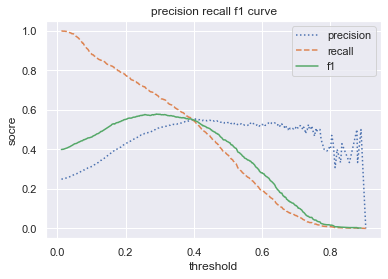

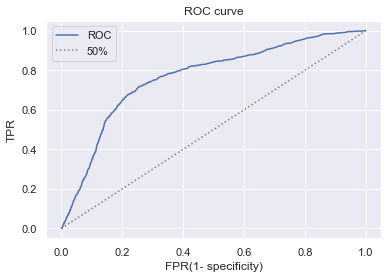

---------------------------------- max_eval ----------------------------------
---------------------------- threshold adjusting  ----------------------------
threshold = 0.2900   f1       = 0.5776   accuracy = 0.7557   AUC      = 0.7655
precision = 0.5055   recall   = 0.6737   
 [[2256  626]
 [ 310  640]]
---------------------------- threshold adjusting  ----------------------------
threshold = 0.2925   f1       = 0.5776   accuracy = 0.7565   AUC      = 0.7655
precision = 0.5068   recall   = 0.6716   
 [[2261  621]
 [ 312  638]]
---------------------------- threshold adjusting  ----------------------------
threshold = 0.2950   f1       = 0.5777   accuracy = 0.7573   AUC      = 0.7655
precision = 0.5080   recall   = 0.6695   
 [[2266  616]
 [ 314  636]]
---------------------------- threshold adjusting  ----------------------------
threshold = 0.2975   f1       = 0.5763   accuracy = 0.7578   AUC      = 0.7655
precision = 0.5089   recall   = 0.6642   
 [[2273  609]
 [ 319  631]]
---------

In [37]:
model = RandomForestClassifier(n_estimators=500, random_state=0)
split_fit_score(X, y, model, th_list=[0.29, 0.2925, 0.295, 0.2975, 0.3]) # best_threshold=0.295

## plots

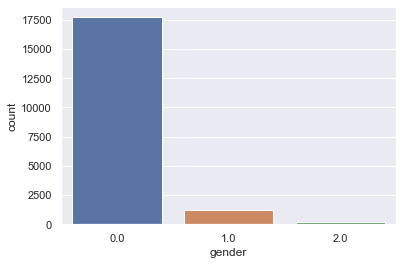

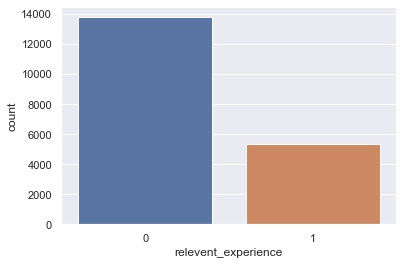

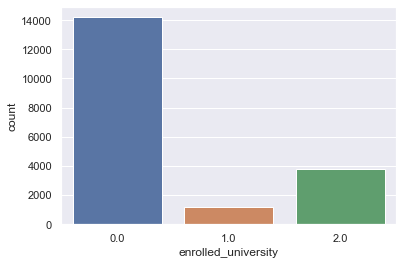

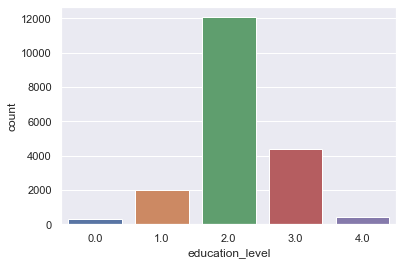

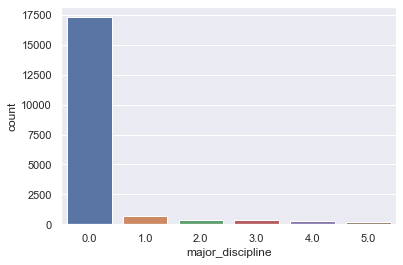

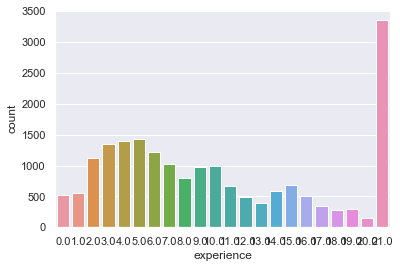

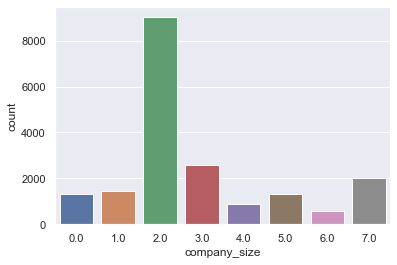

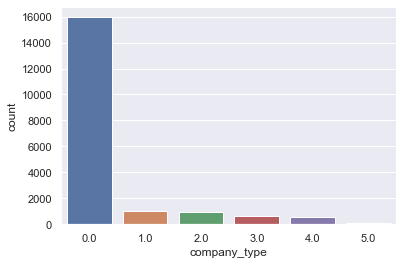

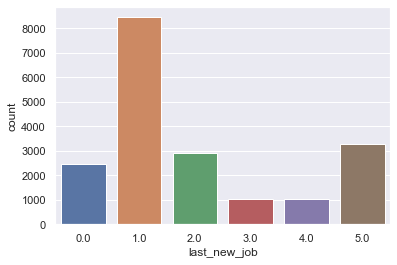

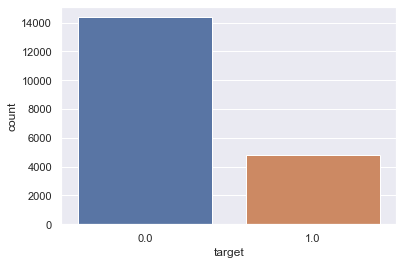

In [38]:
for col in ['gender', 'relevent_experience', 'enrolled_university', 
            'education_level', 'major_discipline', 'experience', 
            'company_size', 'company_type', 'last_new_job', 'target']:
    sns.countplot(col, data=df)
    plt.show()

## corr 상관분석

In [39]:
# 상관분석 ; 두 연속형 변수(x, y) 간 선형적 관계 분석, 인과관계를 설명하지 않음
# ~ 0.1 : 무관
# ~ 0.3 : 약한 상관관계
# ~ 0.7 : 강한 상관관계
# ~ 1.0 : 매우 강한 상관관계, 다중공선성

# 다중공선성 ; 데이터 분석시 부정적 영향
# 1. drop ; 상관관계가 적은 피쳐부터 drop
# 2. PCA(차원축소) ; 피쳐 병합, 원본 데이터 유추 불가능

# 양적 데이터 ; 수치(연속형, 이산형)
# 질적 데이터 ; 범주(명목형, 등급형)

# 피어슨 상관계수 ; 연속형 수치, 일반적으로 사용
# 스피어만 상관계수 ; 범주형 수치

# 분산 ; 한 변수가 퍼져있는 정도
# 공분산 ; 두 변수가 퍼져있는 정도

# 문자열이 있어도 오류가 나지 않지만, 분석에서 제외됨 : 반드시 encode
# 결측치 처리 후 상관분석하는 것이 좋으나, 결측치가 있어도 상관분석 가능

In [40]:
df.corr()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
enrollee_id,1.000000,-0.011356,-0.040455,0.019406,0.043359,0.032212,-0.022972,0.017835,-0.036000,0.005405,-0.006124,-0.027580,0.000998,0.049475
city,-0.011356,1.000000,0.410647,0.020640,0.012156,-0.036280,0.013860,0.038484,0.137939,0.001105,0.028836,0.080799,-0.005665,-0.143475
city_development_index,-0.040455,0.410647,1.000000,0.046069,-0.059808,-0.165555,0.032483,0.083538,0.329124,0.087877,0.028376,0.191410,0.001920,-0.341665
gender,0.019406,0.020640,0.046069,1.000000,0.030271,-0.002444,0.029870,0.050118,-0.037845,0.011468,0.030190,-0.012059,-0.000664,0.008529
relevent_experience,0.043359,0.012156,-0.059808,0.030271,1.000000,0.372919,-0.228537,0.009582,-0.337552,-0.104001,-0.019297,-0.247496,-0.011566,0.128430
enrolled_university,0.032212,-0.036280,-0.165555,-0.002444,0.372919,1.000000,-0.169020,-0.081446,-0.334351,-0.104338,0.012122,-0.237087,-0.003943,0.149539
education_level,-0.022972,0.013860,0.032483,0.029870,-0.228537,-0.169020,1.000000,0.046730,0.273169,0.130228,0.091272,0.195543,-0.011375,-0.011018
major_discipline,0.017835,0.038484,0.083538,0.050118,0.009582,-0.081446,0.046730,1.000000,0.024738,-0.015800,0.014713,0.042710,-0.006533,-0.005966
experience,-0.036000,0.137939,0.329124,-0.037845,-0.337552,-0.334351,0.273169,0.024738,1.000000,0.130320,-0.008201,0.474052,0.001479,-0.174256
company_size,0.005405,0.001105,0.087877,0.011468,-0.104001,-0.104338,0.130228,-0.015800,0.130320,1.000000,-0.048096,0.141026,-0.010114,-0.080316


<AxesSubplot:>

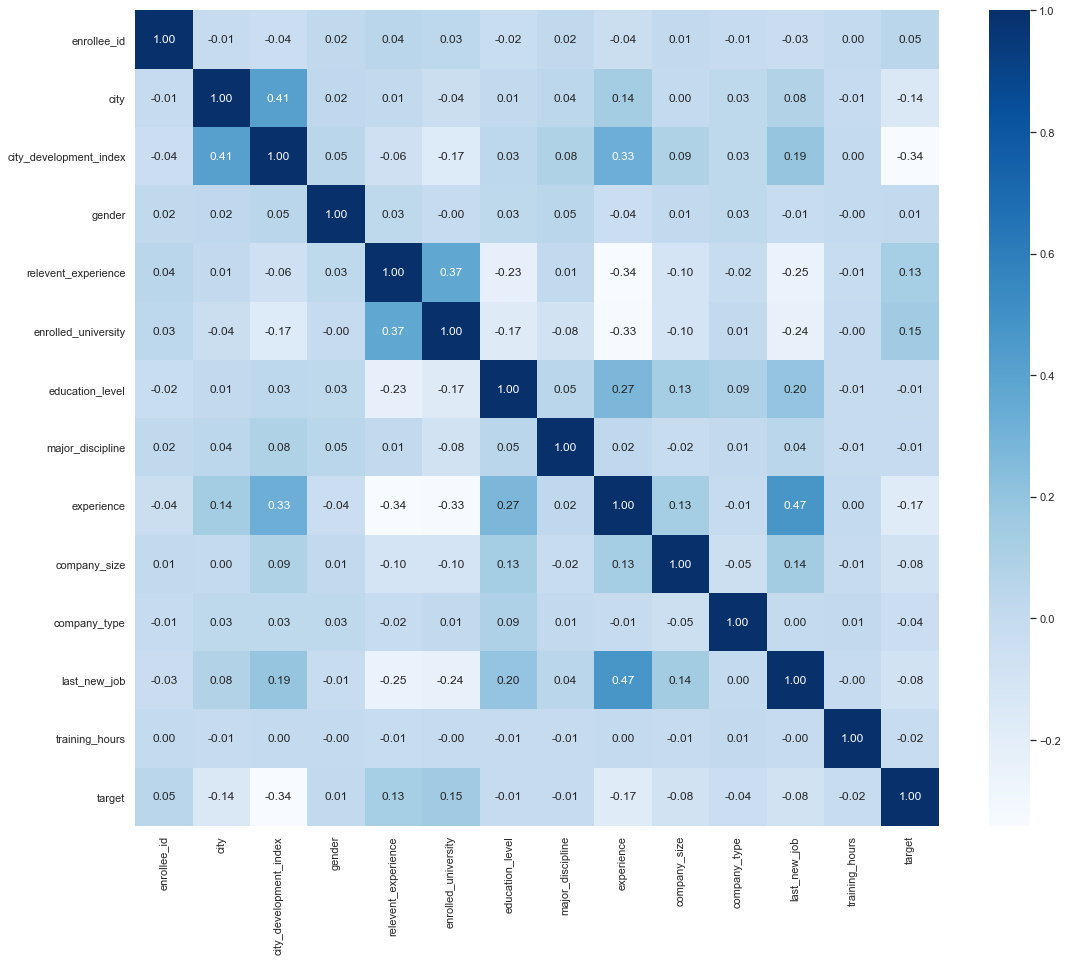

In [41]:
fig, ax = plt.subplots(figsize=(18, 15))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='Blues')

<AxesSubplot:>

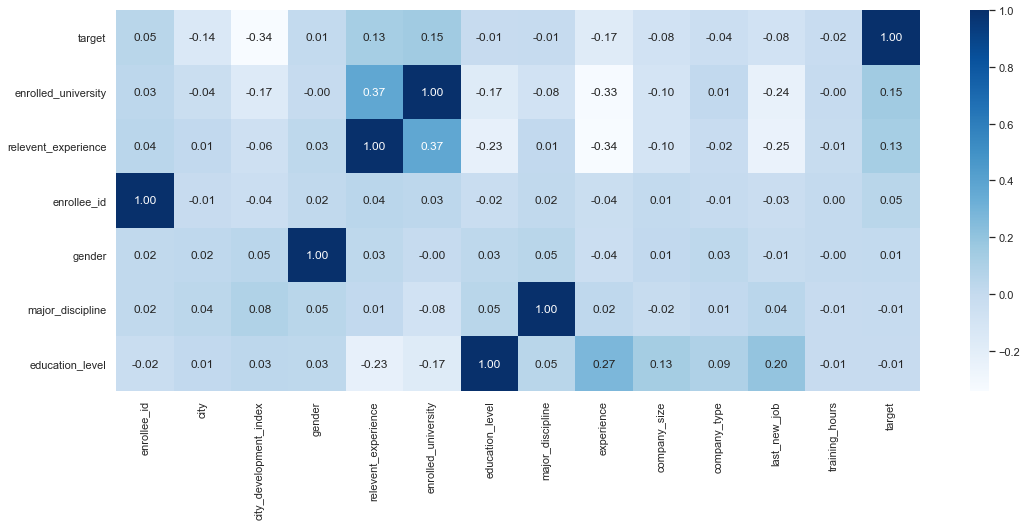

In [42]:
fig, ax = plt.subplots(figsize=(18, 7))
sns.heatmap(df.corr().nlargest(7, 'target'), annot=True, fmt='.2f', cmap='Blues')

## drop cols

In [43]:
drop_cols = ['enrollee_id', ]